In [1]:
import keras
keras.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


'2.1.5'

# 5.1 - Introduction to convnets

This notebook contains the code sample found in Chapter 5, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in Chapter 2, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter 2.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [9]:
from keras import layers
from keras import models

# Architecture 1 (from original notebook example)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Architecture 2 (designed by SM)
model_sm = models.Sequential()
model_sm.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(32, 32, 3)))
model_sm.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_sm.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_sm.add(layers.Dropout(0.25))

model_sm.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_sm.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_sm.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_sm.add(layers.Dropout(0.25))

model_sm.add(layers.Flatten())
model_sm.add(layers.Dense(512, activation='relu'))
model_sm.add(layers.Dropout(0.5))
model_sm.add(layers.Dense(10, activation='softmax'))
# model_sm = models.Sequential()
# model_sm.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model_sm.add(layers.MaxPooling2D((2, 2)))
# model_sm.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_sm.add(layers.MaxPooling2D((2, 2)))
# model_sm.add(layers.Dropout(0.25))
# model_sm.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_sm.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_sm.add(layers.MaxPooling2D((2, 2)))
# model_sm.add(layers.Flatten())
# model_sm.add(layers.Dense(512, activation='relu'))
# model_sm.add(layers.Dense(10, activation='softmax'))

In [10]:
# #model.add(layers.Dropout(0.25))
# #model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# #model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# #model.add(layers.MaxPooling2D((2, 2)))
# #model.add(layers.Dropout(0.25))

Let's display the architecture of our convnet so far:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                65600     
__________

**My model summary**

In [12]:
model_sm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 64)          0         
__________

You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [13]:
#model.summary()

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [14]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

**Instead of using MNIST, load in the cifar10 data (10 class problem using images of animals and objects**
**More difficult image classification problem than MNIST**
**Evaluate both the network designed by Chollet and a network of my own design on the cifar10 data**

In [15]:
from keras.datasets import cifar10
import numpy as np

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

num_train, img_channels, img_rows, img_cols =  train_images.shape
num_test, _, _, _ =  test_images.shape
num_classes = len(np.unique(train_labels))

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(np.unique(y_train))

**To visualize some of the data, generate example images of 10 classes in dataset**

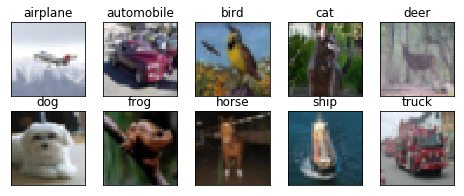

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize examples of each class in cifar10 data
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_images[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::], (1, 2, 0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [17]:
#from keras.datasets import fashion_mnist
from keras.utils import to_categorical

#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape((50000, 32, 32, 3))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 32, 32, 3))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=64)

Epoch 1/10
50000/50000 [==============================] - 9s 174us/step - loss: 1.7293 - acc: 0.3800
Epoch 2/10
50000/50000 [==============================] - 7s 140us/step - loss: 1.3843 - acc: 0.5097
Epoch 3/10
50000/50000 [==============================] - 7s 140us/step - loss: 1.2386 - acc: 0.5614
Epoch 4/10
50000/50000 [==============================] - 7s 140us/step - loss: 1.1382 - acc: 0.6002
Epoch 5/10
50000/50000 [==============================] - 7s 139us/step - loss: 1.0593 - acc: 0.6272
Epoch 6/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.9953 - acc: 0.6496
Epoch 7/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.9374 - acc: 0.6710
Epoch 8/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.8859 - acc: 0.6900
Epoch 9/10
50000/50000 [==============================] - 7s 138us/step - loss: 0.8342 - acc: 0.7074
Epoch 10/10
50000/50000 [==============================] - 7s 138us/step - loss: 0.7867 - a

**Compile my model**

In [19]:
model_sm.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_sm.fit(train_images, train_labels, epochs=10, batch_size=64)

Epoch 1/10
50000/50000 [==============================] - 13s 255us/step - loss: 1.7076 - acc: 0.3883
Epoch 2/10
50000/50000 [==============================] - 12s 246us/step - loss: 1.3703 - acc: 0.5143
Epoch 3/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.2456 - acc: 0.5625
Epoch 4/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.1715 - acc: 0.5892
Epoch 5/10
50000/50000 [==============================] - 12s 246us/step - loss: 1.1230 - acc: 0.6080
Epoch 6/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.0971 - acc: 0.6198
Epoch 7/10
50000/50000 [==============================] - 12s 246us/step - loss: 1.0736 - acc: 0.6281
Epoch 8/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.0596 - acc: 0.6341
Epoch 9/10
50000/50000 [==============================] - 12s 246us/step - loss: 1.0532 - acc: 0.6412
Epoch 10/10
50000/50000 [==============================] - 12s 247us/step - loss: 

Let's evaluate the model on the test data:

In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 92us/step


0.6118

In [21]:
test_loss_sm, test_acc_sm = model_sm.evaluate(test_images, test_labels)
test_acc_sm

10000/10000 [==============================] - 1s 123us/step


0.6167

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 